# Enhanced Rheological Analysis with True Viscosity Comparison

This notebook provides advanced rheological analysis capabilities including:
- **True viscosity comparison**: Overlay theoretical lines on experimental data
- **Enhanced dataset generation**: Comprehensive error analysis with fitted parameters
- **Interactive analysis**: Prompt-based viscosity input for validation
- **Comprehensive error metrics**: Slope and intercept errors vs. known values

## Features:
✓ Interactive true viscosity input and visualization  
✓ Enhanced dataset generation with fitting parameters and uncertainties  
✓ Error analysis comparing experimental vs. theoretical values  
✓ Comprehensive statistical analysis and visualization tools  

*Created: November 21, 2025*

# 1 - Import Required Libraries
Import all necessary libraries for enhanced rheological data analysis:
- pandas: Data manipulation and CSV handling
- numpy: Numerical operations
- matplotlib/seaborn: Visualization
- scipy: Curve fitting for rheological models

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("📚 All libraries imported successfully!")
print("🔬 Enhanced rheology analysis toolkit ready!")

📚 All libraries imported successfully!
🔬 Enhanced rheology analysis toolkit ready!


# 2 - Load Datasets
Load all datasets for enhanced analysis. 
Modify the file paths and names to match your data.
The pipeline will automatically process all loaded datasets.

* Viscometer settings:
     - Brand: Brookfield
     - Model: DV2T
     - Spindle: CPE-52
* Automated data collection setup using CNC machine:
     - Brand: Genmitsu 4040-pro
     - Controller: GRBL
     - Container: 6 cells in a grid of 6x1

In [35]:
# Define file paths for your datasets

# # Si_60K datasets
# file_paths = [
#     'Data/Si_60K/dynamic_analysis_cell_1_20251112_104600.csv',
#     'Data/Si_60K/dynamic_analysis_cell_2_20251112_104600.csv',
#     'Data/Si_60K/dynamic_analysis_cell_3_20251112_104600.csv',
#     'Data/Si_60K/dynamic_analysis_cell_4_20251112_104600.csv',
#     'Data/Si_60K/dynamic_analysis_cell_5_20251112_104600.csv',
#     'Data/Si_60K/dynamic_analysis_cell_6_20251112_104600.csv',
# ]

# # Si_100K_45s datasets
# file_paths = [
#     'Data/Si_100K_duration45s/dynamic_analysis_cell_1_20251117_141310.csv',
#     'Data/Si_100K_duration45s/dynamic_analysis_cell_2_20251117_141310.csv',
#     'Data/Si_100K_duration45s/dynamic_analysis_cell_3_20251117_141310.csv',
#     'Data/Si_100K_duration45s/dynamic_analysis_cell_4_20251117_141310.csv',
#     'Data/Si_100K_duration45s/dynamic_analysis_cell_5_20251117_141310.csv',
#     'Data/Si_100K_duration45s/dynamic_analysis_cell_6_20251117_141310.csv',
# ]

# Si_30K datasets
file_paths = [
    'Data/Si_30K/dynamic_analysis_cell_1_20251120_140913.csv',
    'Data/Si_30K/dynamic_analysis_cell_2_20251120_140913.csv',
    'Data/Si_30K/dynamic_analysis_cell_3_20251120_140913.csv',
    'Data/Si_30K/dynamic_analysis_cell_4_20251120_140913.csv',
    'Data/Si_30K/dynamic_analysis_cell_5_20251120_140913.csv',
    'Data/Si_30K/dynamic_analysis_cell_6_20251120_140913.csv',
]

# Define custom names for each dataset (optional)
dataset_names = [f"Sample {i}" for i in range(1, 7)]

# Load all datasets
datasets = []
for idx, path in enumerate(file_paths):
    try:
        df = pd.read_csv(path)
        datasets.append(df)
        print(f"✓ Loaded: {dataset_names[idx]}")
    except Exception as e:
        print(f"✗ Error loading {path}: {e}")

print(f"\n📊 Total datasets loaded: {len(datasets)}")

# Preview first dataset
if datasets:
    print(f"\n🔍 Preview of {dataset_names[0]}:")
    display(datasets[0].head())
else:
    print("❌ No datasets loaded. Check file paths!")

✓ Loaded: Sample 1
✓ Loaded: Sample 2
✓ Loaded: Sample 3
✓ Loaded: Sample 4
✓ Loaded: Sample 5
✓ Loaded: Sample 6

📊 Total datasets loaded: 6

🔍 Preview of Sample 1:


,Z-Height,RPM_0.1,RPM_0.2,RPM_0.3,RPM_0.5,RPM_0.7,RPM_1.0,RPM_1.5,RPM_2.0,RPM_3.0,RPM_4.5,RPM_6.0,RPM_8.0,RPM_10.0
0,-65.6,1.70,3.39,5.01,8.35,11.73,16.75,25.00,33.31,49.94,74.56,99.18,NaN,NaN
1,-65.7,2.01,3.48,5.17,8.59,12.00,17.12,25.61,34.06,51.00,76.21,96.69,NaN,NaN
2,-65.8,2.34,3.81,5.74,9.59,13.39,19.09,28.61,38.12,57.15,85.31,NaN,NaN,NaN
3,-65.9,2.86,4.61,6.86,11.53,16.12,23.02,34.48,45.94,68.85,94.03,NaN,NaN,NaN
4,-66.0,3.74,5.15,7.81,13.30,18.62,26.54,39.77,53.00,79.32,NaN,NaN,NaN,NaN


# 3 - Define Rheometer Parameters
Set up rheometer geometry and measurement parameters.
These values are used for stress and strain calculations.
Adjust these based on your specific rheometer configuration.

In [36]:
# Rheometer parameters
ALPHA_DEG = 3.0       # Cone half-angle in degrees
R_CM = 1.2            # Cone radius in cm
M_MAX = 7.187e-3      # Maximum torque in N·m (for 100% torque)
GAP_UM = 327          # Gap between cone tip and plate in micrometers

print("🔧 Rheometer Configuration:")
print(f"   Cone angle: {ALPHA_DEG}°")
print(f"   Cone radius: {R_CM} cm")
print(f"   Max torque: {M_MAX} N·m")
print(f"   Gap: {GAP_UM} μm")
print("✅ Parameters set successfully!")

🔧 Rheometer Configuration:
   Cone angle: 3.0°
   Cone radius: 1.2 cm
   Max torque: 0.007187 N·m
   Gap: 327 μm
✅ Parameters set successfully!


# 4 - Core Functions: Stress & Strain Computation
Convert raw torque and speed measurements to fundamental rheological quantities:
- Shear stress (τ, Pa): Force per unit area
- Shear rate (γ̇, 1/s): Velocity gradient in the fluid

Includes finite-gap correction for cone-plate geometry.

In [37]:
def compute_stress_strain(df, alpha_deg, R_cm, M_max, gap_um):
    """
    Compute shear stress (Pa) and shear rate (1/s) from raw measurements.
    Applies finite-gap correction for cone-plate geometry.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with height in first column, torque values in remaining columns
    alpha_deg : float
        Cone half-angle in degrees
    R_cm : float
        Cone radius in cm
    M_max : float
        Maximum torque in N·m (corresponding to 100% torque)
    gap_um : float
        Gap between cone tip and plate in micrometers
    
    Returns:
    --------
    results : dict
        {height_mm: (gamma_dot_array, tau_array)}
        gamma_dot: shear rate in 1/s
        tau: shear stress in Pa
    """
    # Convert units
    alpha = np.deg2rad(alpha_deg)  # degrees to radians
    R = R_cm / 100.0               # cm to meters
    h0 = gap_um * 1e-6             # micrometers to meters
    
    # Finite-gap correction factor
    # Accounts for deviation from ideal cone-plate geometry
    fc = 1 - (3 * h0) / (2 * R * np.tan(alpha))
    
    # Extract RPM values from column headers
    speed_labels = df.columns[1:]
    speeds = np.array([float(label.replace('RPM_', '')) for label in speed_labels])
    
    results = {}
    
    for i in range(len(df)):
        height = df.iloc[i, 0]
        torque_percent = df.iloc[i, 1:].values
        
        # Convert torque from % to N·m
        torque = (torque_percent / 100) * M_max
        
        # Calculate shear stress with finite-gap correction
        # Formula: τ = fc * (3M) / (2πR³)
        tau = fc * (3 * torque) / (2 * np.pi * R**3)  # Pa
        
        # Calculate shear rate
        # Convert RPM to angular velocity (rad/s)
        Omega = 2 * np.pi * speeds / 60  # rad/s
        # For cone-plate: γ̇ = Ω / tan(α)
        gamma_dot = Omega / np.tan(alpha)  # 1/s
        
        results[height] = (gamma_dot, tau)
    
    return results


def power_law(gamma_dot, K, n):
    """
    Power-law fluid model: τ = K·γ̇ⁿ
    
    Parameters:
    -----------
    gamma_dot : array
        Shear rate (1/s)
    K : float
        Consistency index (Pa·sⁿ)
    n : float
        Flow behavior index (dimensionless)
    
    Returns:
    --------
    tau : array
        Shear stress (Pa)
    """
    return K * gamma_dot**n


def linear_model(gamma_dot, a, b):
    """
    Linear (Newtonian) model: τ = a·γ̇ + b
    
    Parameters:
    -----------
    gamma_dot : array
        Shear rate (1/s)
    a : float
        Slope = viscosity (Pa·s)
    b : float
        Intercept (Pa), ideally close to zero
    
    Returns:
    --------
    tau : array
        Shear stress (Pa)
    """
    return a * gamma_dot + b

print("✅ Core functions defined successfully!")
print("🧮 Ready for stress-strain calculations!")

✅ Core functions defined successfully!
🧮 Ready for stress-strain calculations!


# 🆕 5 - Enhanced Function: Plot with True Viscosity Overlay
**NEW FEATURE:** Enhanced plotting function that overlays theoretical viscosity lines.
- Shows ideal τ = μ·γ̇ relationship (zero intercept)
- Interactive viscosity input for comparison
- Validates experimental fits against known material properties

In [38]:
def plot_fitted_stress_strain_with_true_viscosity(datasets, dataset_names, alpha_deg, R_cm, 
                                                  M_max, gap_um, true_viscosity_cp=None, 
                                                  fit_method="linear"):
    """
    🆕 ENHANCED: Plot τ vs γ̇ with fitted curves and optional true viscosity line.
    
    Parameters:
    -----------
    datasets : list of pd.DataFrame
        List of datasets to analyze
    dataset_names : list of str
        Names for each dataset
    alpha_deg, R_cm, M_max, gap_um : float
        Rheometer parameters
    true_viscosity_cp : float or None
        True/known viscosity in cP. If provided, plots theoretical line τ = μ·γ̇
    fit_method : str
        "linear" or "power_law"
    """
    # Ask for true viscosity if not provided and method is linear
    if true_viscosity_cp is None and fit_method == "linear":
        while True:
            try:
                user_input = input("🔬 Enter the true/known viscosity of the Newtonian liquid in cP (or 'skip'): ")
                if user_input.lower() == 'skip':
                    true_viscosity_cp = None
                    break
                true_viscosity_cp = float(user_input)
                if true_viscosity_cp > 0:
                    break
                else:
                    print("⚠️ Please enter a positive value.")
            except ValueError:
                print("⚠️ Please enter a valid number or 'skip'.")
    
    n_datasets = len(datasets)
    ncols = 3
    nrows = (n_datasets + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows),
                            sharex=True, sharey=True)
    if n_datasets == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, df in enumerate(datasets):
        ax = axes[idx]
        
        # Compute stress and strain for this dataset
        results = compute_stress_strain(df, alpha_deg, R_cm, M_max, gap_um)
        
        # Track all shear rate values for plotting true viscosity line
        all_gamma_dot = []
        
        for h, (gdot, tau) in results.items():
            # Filter positive values only (required for log scale)
            mask = (gdot > 0) & (tau > 0)
            gdot_fit, tau_fit = gdot[mask], tau[mask]
            
            if len(gdot_fit) < 3:  # Need at least 3 points to fit
                continue
                
            # Store shear rate values for true viscosity line
            all_gamma_dot.extend(gdot_fit)
            
            # Fit the selected model
            if fit_method == "power_law":
                model = power_law
                p0 = [0.1, 1]  # Initial guess: K=0.1, n=1
                popt, _ = curve_fit(model, gdot_fit, tau_fit, p0=p0)
                K, n = popt
                
                # Generate smooth curve for plotting
                g_line = np.logspace(np.log10(gdot_fit.min()), 
                                    np.log10(gdot_fit.max()), 100)
                tau_line = model(g_line, *popt)
                label_fit = f"Fit h={h:.2f}: τ={K:.2e}·γ̇^{n:.2f}"
            
            elif fit_method == "linear":
                model = linear_model
                p0 = [1, 0]  # Initial guess: slope=1, intercept=0
                popt, _ = curve_fit(model, gdot_fit, tau_fit, p0=p0)
                a, b = popt
                
                # Generate smooth line for plotting
                g_line = np.linspace(gdot_fit.min(), gdot_fit.max(), 100)
                tau_line = model(g_line, *popt)
                label_fit = f"Fit h={h:.2f}: τ={a:.2e}·γ̇+{b:.2e}"
            
            # Plot experimental data and fitted curve
            ax.scatter(gdot_fit, tau_fit, s=20, label=f"h={h:.2f} mm")
            ax.plot(g_line, tau_line, '--', lw=1.2, label=label_fit)
        
        # 🆕 Plot true viscosity line if provided and method is linear
        if true_viscosity_cp is not None and fit_method == "linear" and all_gamma_dot:
            # Convert viscosity from cP to Pa·s
            true_viscosity_pas = true_viscosity_cp / 1000
            
            # Create shear rate range for true viscosity line
            gamma_min = min(all_gamma_dot)
            gamma_max = max(all_gamma_dot)
            gamma_true = np.linspace(gamma_min, gamma_max, 100)
            tau_true = true_viscosity_pas * gamma_true  # τ = μ·γ̇ (zero intercept)
            
            ax.plot(gamma_true, tau_true, 'r-', lw=2.5, 
                   label=f"🎯 True: τ={true_viscosity_cp} cP·γ̇", alpha=0.8)
        
        # Set scale (log for power-law, linear for Newtonian)
        if fit_method == "power_law":
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        # Formatting
        ax.set_xlabel("Shear Rate γ̇ (1/s)")
        ax.set_ylabel("Shear Stress τ (Pa)")
        title = f"{dataset_names[idx]} ({fit_method.replace('_',' ').title()})"
        if true_viscosity_cp is not None and fit_method == "linear":
            title += f"\n🎯 True μ = {true_viscosity_cp} cP"
        ax.set_title(title)
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend(fontsize="x-small", frameon=False)
    
    # Hide unused subplots
    for idx in range(n_datasets, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ Enhanced plotting function with true viscosity overlay ready!")
print("🎯 Interactive viscosity validation available!")

✅ Enhanced plotting function with true viscosity overlay ready!
🎯 Interactive viscosity validation available!


# 🆕 6 - Enhanced Function: Generate Dataset with Fitting Parameters
**NEW FEATURE:** Creates comprehensive datasets with fitted line parameters and error analysis.
- Extracts slope (viscosity) and intercept from fitted lines
- Calculates uncertainties from curve fitting covariance matrix
- Computes percentage errors compared to true viscosity values
- Provides detailed quality assessment metrics

In [39]:
def generate_enhanced_dataset(datasets, dataset_names, alpha_deg, R_cm, 
                             M_max, gap_um, true_viscosity_cp=None):
    """
    🆕 ENHANCED: Generate dataset with fitting parameters and error analysis.
    
    Parameters:
    -----------
    datasets : list of pd.DataFrame
        List of datasets to analyze
    dataset_names : list of str
        Names for each dataset
    alpha_deg, R_cm, M_max, gap_um : float
        Rheometer parameters
    true_viscosity_cp : float or None
        True/known viscosity in cP for error calculation
    
    Returns:
    --------
    enhanced_datasets : list of pd.DataFrame
        Each DataFrame contains: height, slope, intercept, uncertainties, errors
    """
    # Ask for true viscosity if not provided
    if true_viscosity_cp is None:
        while True:
            try:
                user_input = input("🔬 Enter the true/known viscosity in cP (or 'skip' for no error calc): ")
                if user_input.lower() == 'skip':
                    true_viscosity_cp = None
                    break
                true_viscosity_cp = float(user_input)
                if true_viscosity_cp > 0:
                    break
                else:
                    print("⚠️ Please enter a positive value.")
            except ValueError:
                print("⚠️ Please enter a valid number or 'skip'.")
    
    enhanced_datasets = []
    
    # Convert true viscosity from cP to Pa·s for calculations
    true_viscosity_pas = true_viscosity_cp / 1000 if true_viscosity_cp is not None else None
    true_intercept = 0.0  # Theoretical intercept for Newtonian fluid is 0
    
    for idx, df in enumerate(datasets):
        print(f"\n🔬 Processing {dataset_names[idx]}...")
        
        # Compute stress and strain for this dataset
        results = compute_stress_strain(df, alpha_deg, R_cm, M_max, gap_um)
        
        # Create enhanced data for this dataset
        enhanced_data = []
        
        for h, (gdot, tau) in results.items():
            # Filter positive values only
            mask = (gdot > 0) & (tau > 0)
            gdot_fit, tau_fit = gdot[mask], tau[mask]
            
            if len(gdot_fit) < 3:  # Need at least 3 points to fit
                print(f"   ⚠️  Skipping height {h:.3f} mm (insufficient data points)")
                continue
            
            try:
                # Fit linear model: τ = a·γ̇ + b
                popt, pcov = curve_fit(linear_model, gdot_fit, tau_fit, p0=[1, 0])
                slope, intercept = popt
                
                # Calculate parameter uncertainties from covariance matrix
                param_errors = np.sqrt(np.diag(pcov))
                slope_uncertainty, intercept_uncertainty = param_errors
                
                # Calculate errors compared to true values (if available)
                if true_viscosity_pas is not None:
                    slope_error = abs(slope - true_viscosity_pas) / true_viscosity_pas * 100  # % error
                    intercept_error = abs(intercept - true_intercept)  # Absolute error in Pa
                else:
                    slope_error = np.nan
                    intercept_error = np.nan
                
                # Store the enhanced data
                enhanced_data.append({
                    'height_mm': h,
                    'slope_Pa_s': slope,
                    'intercept_Pa': intercept,
                    'slope_uncertainty_Pa_s': slope_uncertainty,
                    'intercept_uncertainty_Pa': intercept_uncertainty,
                    'slope_error_percent': slope_error,
                    'intercept_error_Pa': intercept_error,
                    'viscosity_cP': slope * 1000  # Convert to cP for convenience
                })
                
                print(f"   ✅ Height {h:.3f} mm: μ = {slope*1000:.1f} cP, intercept = {intercept:.3f} Pa")
                
            except Exception as e:
                print(f"   ❌ Error fitting height {h:.3f} mm: {e}")
                continue
        
        # Convert to DataFrame
        if enhanced_data:
            enhanced_df = pd.DataFrame(enhanced_data)
            enhanced_datasets.append(enhanced_df)
            print(f"   📊 Generated enhanced dataset with {len(enhanced_data)} valid measurements")
        else:
            enhanced_datasets.append(pd.DataFrame())  # Empty DataFrame
            print(f"   ⚠️  No valid measurements for {dataset_names[idx]}")
    
    return enhanced_datasets

print("✅ Enhanced dataset generation function ready!")
print("📊 Comprehensive fitting analysis with error metrics available!")

✅ Enhanced dataset generation function ready!
📊 Comprehensive fitting analysis with error metrics available!


# 🚀 7 - Execute Enhanced Dataset Generation
Run the enhanced analysis to create comprehensive datasets with fitting parameters and error analysis.
This will generate detailed datasets containing slopes, intercepts, uncertainties, and error metrics.

In [40]:
# Generate enhanced datasets with fitting parameters and error analysis
print("🚀 Starting enhanced dataset generation...")

# This will prompt you to enter the known viscosity for error calculation
enhanced_datasets = generate_enhanced_dataset(datasets, dataset_names, ALPHA_DEG, R_CM, 
                                             M_MAX, GAP_UM)

# Display the enhanced datasets summary
print("\n" + "="*80)
print("📊 ENHANCED DATASETS SUMMARY")
print("="*80)

for idx, (enhanced_df, name) in enumerate(zip(enhanced_datasets, dataset_names)):
    if not enhanced_df.empty:
        print(f"\n🔬 {name}:")
        print(f"   📐 Shape: {enhanced_df.shape}")
        print(f"   📋 Columns: {list(enhanced_df.columns)}")
        print(f"   📊 Mean viscosity: {enhanced_df['viscosity_cP'].mean():.1f} ± {enhanced_df['viscosity_cP'].std():.1f} cP")
        
        if not enhanced_df['slope_error_percent'].isna().all():
            print(f"   📈 Mean slope error: {enhanced_df['slope_error_percent'].mean():.2f}%")
            print(f"   📉 Mean intercept error: {enhanced_df['intercept_error_Pa'].mean():.4f} Pa")
        
        # Display first few rows
        print(f"\n   🔍 Preview:")
        display(enhanced_df.round(4))
    else:
        print(f"\n❌ {name}: No valid data")

print("\n✅ Enhanced dataset generation complete!")

# Store for further analysis
print(f"💾 Enhanced datasets stored in 'enhanced_datasets' variable")
print(f"📝 Total enhanced datasets: {len([df for df in enhanced_datasets if not df.empty])}")

# Alternative: You can also specify the true viscosity directly (example: 60000 cP)
# enhanced_datasets = generate_enhanced_dataset(datasets, dataset_names, ALPHA_DEG, R_CM, 
#                                              M_MAX, GAP_UM, true_viscosity_cp=60000)

🚀 Starting enhanced dataset generation...

🔬 Processing Sample 1...
   ✅ Height -65.600 mm: μ = 36158.7 cP, intercept = 0.619 Pa
   ✅ Height -65.700 mm: μ = 35777.4 cP, intercept = 3.190 Pa
   ✅ Height -65.800 mm: μ = 41427.3 cP, intercept = 0.762 Pa
   ✅ Height -65.900 mm: μ = 46656.0 cP, intercept = 6.075 Pa
   ✅ Height -66.000 mm: μ = 57610.9 cP, intercept = 1.100 Pa
   ✅ Height -66.100 mm: μ = 67989.8 cP, intercept = 1.452 Pa
   ✅ Height -66.200 mm: μ = 69902.2 cP, intercept = 33.998 Pa
   ✅ Height -66.300 mm: μ = 69606.7 cP, intercept = 44.368 Pa
   ✅ Height -66.400 mm: μ = 64434.3 cP, intercept = 50.989 Pa
   ✅ Height -66.500 mm: μ = 56931.1 cP, intercept = 71.822 Pa
   ✅ Height -66.600 mm: μ = 69453.1 cP, intercept = 31.158 Pa
   ✅ Height -66.700 mm: μ = -2775.9 cP, intercept = 412.802 Pa
   📊 Generated enhanced dataset with 12 valid measurements

🔬 Processing Sample 2...
   ✅ Height -65.600 mm: μ = 41688.6 cP, intercept = 0.090 Pa
   ✅ Height -65.700 mm: μ = 47232.3 cP, interce

,height_mm,slope_Pa_s,intercept_Pa,slope_uncertainty_Pa_s,intercept_uncertainty_Pa,slope_error_percent,intercept_error_Pa,viscosity_cP
0,-65.6,36.1587,0.6191,0.0393,0.2028,20.5291,0.6191,36158.7297
1,-65.7,35.7774,3.1903,0.3928,2.0273,19.2581,3.1903,35777.4229
2,-65.8,41.4273,0.7621,0.0708,0.2735,38.0911,0.7621,41427.3449
3,-65.9,46.6560,6.0750,1.0022,3.8717,55.5199,6.0750,46655.9627
4,-66.0,57.6109,1.1004,0.3035,0.8367,92.0364,1.1004,57610.9275
5,-66.1,67.9898,1.4525,0.3518,0.9697,126.6327,1.4525,67989.8189
6,-66.2,69.9022,33.9984,4.0086,11.0505,133.0073,33.9984,69902.1920
7,-66.3,69.6067,44.3682,3.9805,10.9730,132.0224,44.3682,69606.7129
8,-66.4,64.4343,50.9888,3.3015,9.1013,114.7809,50.9888,64434.2806
9,-66.5,56.9311,71.8224,5.8388,16.0958,89.7702,71.8224,56931.0738



🔬 Sample 2:
   📐 Shape: (12, 8)
   📋 Columns: ['height_mm', 'slope_Pa_s', 'intercept_Pa', 'slope_uncertainty_Pa_s', 'intercept_uncertainty_Pa', 'slope_error_percent', 'intercept_error_Pa', 'viscosity_cP']
   📊 Mean viscosity: 44465.5 ± 27982.3 cP
   📈 Mean slope error: 97.57%
   📉 Mean intercept error: 108.5398 Pa

   🔍 Preview:


,height_mm,slope_Pa_s,intercept_Pa,slope_uncertainty_Pa_s,intercept_uncertainty_Pa,slope_error_percent,intercept_error_Pa,viscosity_cP
0,-65.6,41.6886,0.0899,0.0359,0.1387,38.9619,0.0899,41688.5788
1,-65.7,47.2323,0.9417,0.1067,0.4121,57.4409,0.9417,47232.2711
2,-65.8,48.7918,10.4812,1.7648,6.8181,62.6394,10.4812,48791.8273
3,-65.9,64.8728,1.6635,0.3905,1.0764,116.2428,1.6635,64872.8457
4,-66.0,66.8541,50.8042,3.9601,10.9168,122.8471,50.8042,66854.1445
5,-66.1,65.9910,35.9513,2.7022,7.4492,119.9699,35.9513,65990.9738
6,-66.2,62.5799,45.4562,4.4062,12.1466,108.5996,45.4562,62579.8788
7,-66.3,65.3143,37.4018,2.7678,7.6301,117.7144,37.4018,65314.3192
8,-66.4,69.0947,30.5188,4.0121,11.0602,130.3156,30.5188,69094.6659
9,-66.5,0.3468,362.4614,0.1435,1.2249,98.8439,362.4614,346.8425



🔬 Sample 3:
   📐 Shape: (10, 8)
   📋 Columns: ['height_mm', 'slope_Pa_s', 'intercept_Pa', 'slope_uncertainty_Pa_s', 'intercept_uncertainty_Pa', 'slope_error_percent', 'intercept_error_Pa', 'viscosity_cP']
   📊 Mean viscosity: 54192.5 ± 22561.4 cP
   📈 Mean slope error: 104.01%
   📉 Mean intercept error: 48.9096 Pa

   🔍 Preview:


,height_mm,slope_Pa_s,intercept_Pa,slope_uncertainty_Pa_s,intercept_uncertainty_Pa,slope_error_percent,intercept_error_Pa,viscosity_cP
0,-65.6,44.5672,0.1885,0.0443,0.1710,48.5575,0.1885,44567.2351
1,-65.7,45.9515,9.1275,1.4985,5.7889,53.1717,9.1275,45951.5061
2,-65.8,59.7934,1.5420,0.3097,0.8537,99.3113,1.5420,59793.3807
3,-65.9,67.7793,7.4226,1.5331,4.2263,125.9309,7.4226,67779.2611
4,-66.0,69.9064,20.0154,2.9817,8.2196,133.0212,20.0154,69906.3604
5,-66.1,65.0590,34.6078,2.6144,7.2072,116.8632,34.6078,65058.9742
6,-66.2,65.5973,33.5837,2.6785,7.3839,118.6576,33.5837,65597.2928
7,-66.3,63.3911,35.1674,2.6188,7.2194,111.3036,35.1674,63391.0888
8,-66.4,64.9298,36.9575,3.4404,9.4842,116.4328,36.9575,64929.8479
9,-66.5,-5.0499,310.4833,5.8664,22.6632,116.8330,310.4833,-5049.8976



🔬 Sample 4:
   📐 Shape: (8, 8)
   📋 Columns: ['height_mm', 'slope_Pa_s', 'intercept_Pa', 'slope_uncertainty_Pa_s', 'intercept_uncertainty_Pa', 'slope_error_percent', 'intercept_error_Pa', 'viscosity_cP']
   📊 Mean viscosity: 58014.1 ± 20220.7 cP
   📈 Mean slope error: 111.35%
   📉 Mean intercept error: 46.9768 Pa

   🔍 Preview:


,height_mm,slope_Pa_s,intercept_Pa,slope_uncertainty_Pa_s,intercept_uncertainty_Pa,slope_error_percent,intercept_error_Pa,viscosity_cP
0,-65.6,59.9386,0.3196,0.0317,0.0874,99.7953,0.3196,59938.5996
1,-65.7,69.7530,1.6187,0.3364,0.9273,132.5100,1.6187,69752.9984
2,-65.8,66.0381,19.3936,1.8506,5.1017,120.1270,19.3936,66038.0876
3,-65.9,66.5879,27.1634,2.3898,6.5880,121.9598,27.1634,66587.9420
4,-66.0,64.6975,22.7395,3.5220,9.7092,115.6583,22.7395,64697.4778
5,-66.1,64.5469,21.8655,3.4040,9.3838,115.1564,21.8655,64546.9271
6,-66.2,64.1165,15.0193,3.7908,10.4500,113.7217,15.0193,64116.5048
7,-66.3,8.4345,267.6951,1.3569,7.0028,71.8851,267.6951,8434.4737



🔬 Sample 5:
   📐 Shape: (9, 8)
   📋 Columns: ['height_mm', 'slope_Pa_s', 'intercept_Pa', 'slope_uncertainty_Pa_s', 'intercept_uncertainty_Pa', 'slope_error_percent', 'intercept_error_Pa', 'viscosity_cP']
   📊 Mean viscosity: 47753.2 ± 26153.0 cP
   📈 Mean slope error: 97.44%
   📉 Mean intercept error: 81.0119 Pa

   🔍 Preview:


,height_mm,slope_Pa_s,intercept_Pa,slope_uncertainty_Pa_s,intercept_uncertainty_Pa,slope_error_percent,intercept_error_Pa,viscosity_cP
0,-65.6,46.3116,5.3814,0.9999,3.8629,54.3720,5.3814,46311.5945
1,-65.7,60.8005,1.6329,0.2438,0.6721,102.6684,1.6329,60800.5102
2,-65.8,68.4228,11.9983,0.3806,1.0491,128.0759,11.9983,68422.7615
3,-65.9,67.8480,12.1994,0.8984,2.4766,126.1600,12.1994,67847.9930
4,-66.0,67.9391,9.2387,3.1682,8.7339,126.4637,9.2387,67939.1183
5,-66.1,63.8833,21.1091,3.2809,9.0446,112.9442,21.1091,63883.2626
6,-66.2,46.2242,86.7677,10.8439,29.8933,54.0808,86.7677,46224.2280
7,-66.3,4.5785,219.6862,2.7083,23.1245,84.7383,219.6862,4578.5095
8,-66.4,3.7710,361.0933,0.4527,3.0608,87.4301,361.0933,3770.9555



🔬 Sample 6:
   📐 Shape: (12, 8)
   📋 Columns: ['height_mm', 'slope_Pa_s', 'intercept_Pa', 'slope_uncertainty_Pa_s', 'intercept_uncertainty_Pa', 'slope_error_percent', 'intercept_error_Pa', 'viscosity_cP']
   📊 Mean viscosity: 36478.5 ± 28483.1 cP
   📈 Mean slope error: 86.39%
   📉 Mean intercept error: 130.0903 Pa

   🔍 Preview:


,height_mm,slope_Pa_s,intercept_Pa,slope_uncertainty_Pa_s,intercept_uncertainty_Pa,slope_error_percent,intercept_error_Pa,viscosity_cP
0,-65.6,25.9429,-3.1248,0.0438,0.2963,13.5238,3.1248,25942.8637
1,-65.7,36.3545,2.9900,0.6512,3.3608,21.1816,2.9900,36354.4827
2,-65.8,46.5765,4.0786,0.6644,2.5668,55.2549,4.0786,46576.4783
3,-65.9,59.0108,0.9583,0.2658,0.7328,96.7026,0.9583,59010.7687
4,-66.0,66.7346,28.9533,2.5956,7.1552,122.4487,28.9533,66734.6151
5,-66.1,67.0720,7.1204,3.5700,9.8414,123.5732,7.1204,67071.9730
6,-66.2,65.2836,20.1843,4.0165,11.0724,117.6120,20.1843,65283.5886
7,-66.3,63.3472,16.3651,3.1709,8.7413,111.1572,16.3651,63347.1741
8,-66.4,3.8303,283.9363,0.4794,4.0931,87.2324,283.9363,3830.2901
9,-66.5,1.0847,385.7256,0.1678,1.4328,96.3843,385.7256,1084.7123



✅ Enhanced dataset generation complete!
💾 Enhanced datasets stored in 'enhanced_datasets' variable
📝 Total enhanced datasets: 6


# 🔍 Filter: Low Intercept Measurements
Filter and display measurements where the fitted line intercept is below 10 Pa.
Low intercepts indicate better Newtonian behavior (ideal intercept = 0 Pa).

🔍 FILTERING & PLOTTING: Measurements with intercept < 10 Pa
📊 Sample 1: 6/12 measurements (50.0%)
📊 Sample 2: 3/12 measurements (25.0%)
📊 Sample 3: 4/10 measurements (40.0%)
📊 Sample 4: 2/8 measurements (25.0%)
📊 Sample 5: 3/9 measurements (33.3%)
📊 Sample 6: 5/12 measurements (41.7%)

📈 OVERALL: 23/63 measurements (36.5%) meet criteria

🎨 Creating plots for 6 samples with low-intercept measurements...


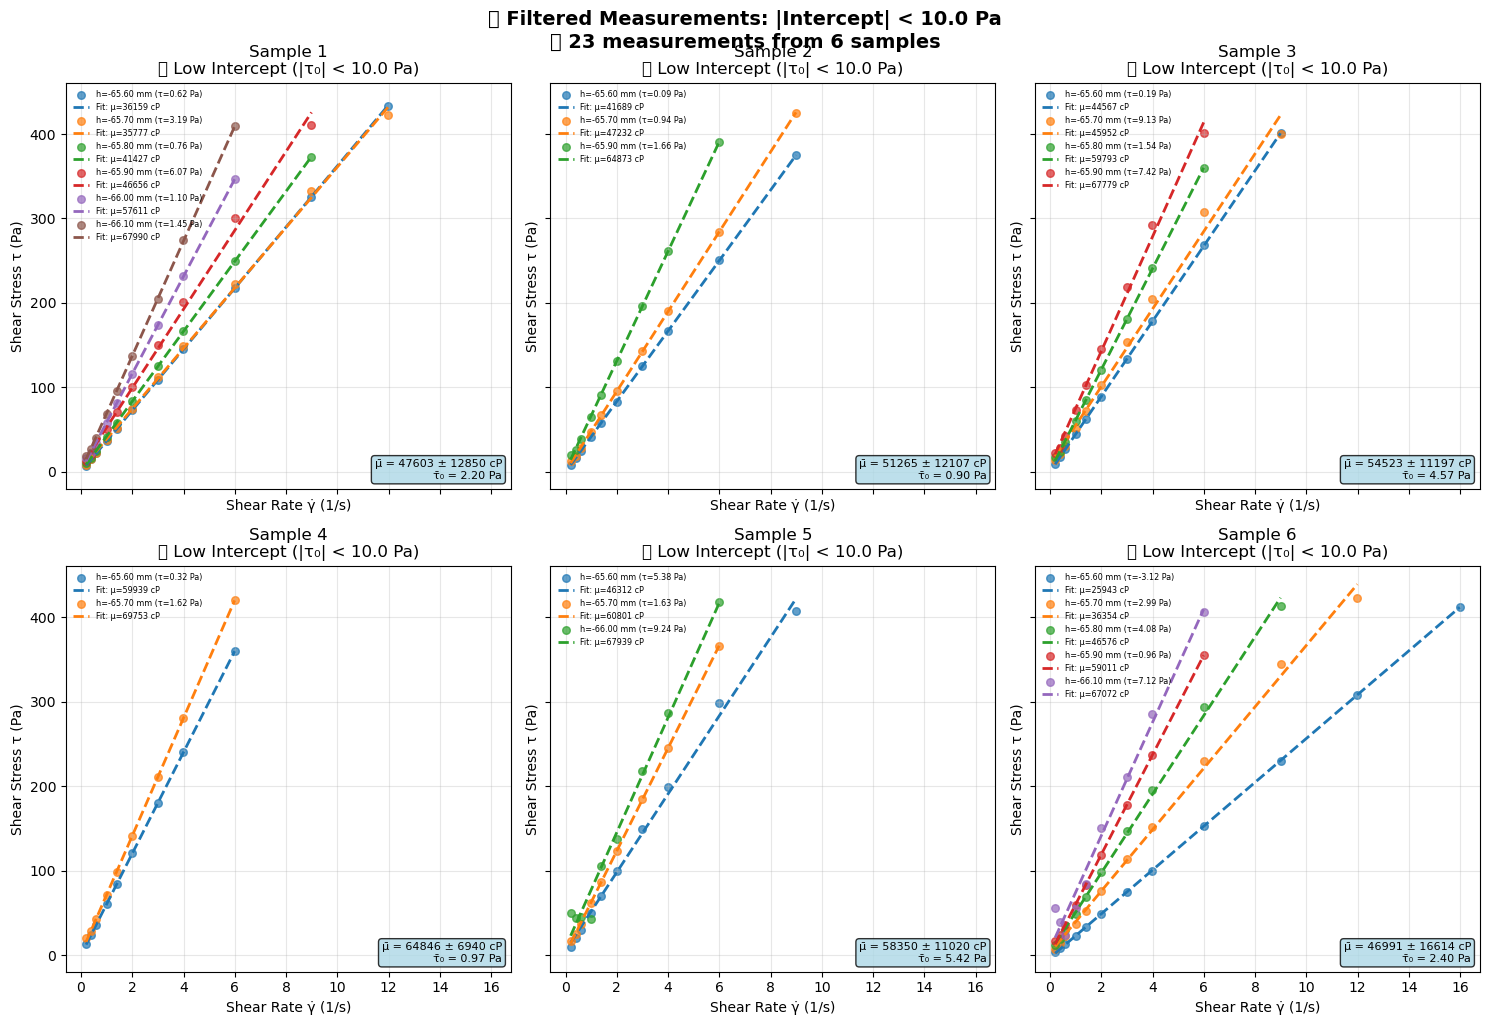

✅ Visualization complete!
💡 Only measurements with good Newtonian behavior (low intercept) are shown

💾 Combined low-intercept data stored in 'combined_low_intercept' variable
   Shape: (23, 9)
   Mean viscosity: 52052.4 ± 12808.7 cP


In [ ]:
# Filter and plot measurements with intercept < 10 Pa
intercept_threshold = 10.0  # Pa

print("🔍 FILTERING & PLOTTING: Measurements with intercept < 10 Pa")
print("="*60)

# Ask for true viscosity for overlay
true_viscosity_cp = None
while True:
    try:
        user_input = input("🔬 Enter the true/known viscosity in cP for overlay (or 'skip'): ")
        if user_input.lower() == 'skip':
            true_viscosity_cp = None
            break
        true_viscosity_cp = float(user_input)
        if true_viscosity_cp > 0:
            break
        else:
            print("⚠️ Please enter a positive value.")
    except ValueError:
        print("⚠️ Please enter a valid number or 'skip'.")

# Collect summary statistics
filtered_count = 0
total_count = 0
samples_with_data = []

# First pass: collect statistics and filter data
for idx, (enhanced_df, name) in enumerate(zip(enhanced_datasets, dataset_names)):
    if not enhanced_df.empty:
        # Filter rows with low intercept
        low_intercept_rows = enhanced_df[abs(enhanced_df['intercept_Pa']) < intercept_threshold]
        
        total_measurements = len(enhanced_df)
        filtered_measurements = len(low_intercept_rows)
        
        total_count += total_measurements
        filtered_count += filtered_measurements
        
        print(f"📊 {name}: {filtered_measurements}/{total_measurements} measurements " +
              f"({(filtered_measurements/total_measurements*100):.1f}%)")
        
        if not low_intercept_rows.empty:
            samples_with_data.append((idx, name, enhanced_df, low_intercept_rows))

print(f"\n📈 OVERALL: {filtered_count}/{total_count} measurements " +
      f"({(filtered_count/total_count*100 if total_count > 0 else 0):.1f}%) meet criteria")

# Create visualization for samples with low-intercept data
if samples_with_data:
    print(f"\n🎨 Creating plots for {len(samples_with_data)} samples with low-intercept measurements...")
    
    # Setup plot grid
    n_samples = len(samples_with_data)
    ncols = 3
    nrows = (n_samples + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows), sharex=True, sharey=True)
    if n_samples == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot each sample
    for plot_idx, (sample_idx, name, full_df, filtered_df) in enumerate(samples_with_data):
        ax = axes[plot_idx]
        
        # Get the original dataset for this sample to compute stress-strain
        original_df = datasets[sample_idx]
        results = compute_stress_strain(original_df, ALPHA_DEG, R_CM, M_MAX, GAP_UM)
        
        # Get heights that passed the filter
        filtered_heights = set(filtered_df['height_mm'].values)
        
        # Track shear rate range for consistent axis scaling and true viscosity line
        all_gamma_dot = []
        
        # Plot only the filtered heights
        for h, (gdot, tau) in results.items():
            if h not in filtered_heights:
                continue
                
            # Filter positive values
            mask = (gdot > 0) & (tau > 0)
            gdot_fit, tau_fit = gdot[mask], tau[mask]
            
            if len(gdot_fit) < 3:
                continue
            
            all_gamma_dot.extend(gdot_fit)
            
            # Get fitted parameters for this height
            height_data = filtered_df[filtered_df['height_mm'] == h].iloc[0]
            slope = height_data['slope_Pa_s']
            intercept = height_data['intercept_Pa']
            
            # Generate fitted line
            g_line = np.linspace(gdot_fit.min(), gdot_fit.max(), 100)
            tau_line = slope * g_line + intercept
            
            # Plot experimental data and fitted line
            ax.scatter(gdot_fit, tau_fit, s=30, alpha=0.7, 
                      label=f"h={h:.2f} mm (τ₀={intercept:.2f} Pa)")
            ax.plot(g_line, tau_line, '--', lw=2, 
                   label=f"Fit: μ={slope*1000:.0f} cP")
        
        # 🆕 Plot true viscosity line if provided
        if true_viscosity_cp is not None and all_gamma_dot:
            # Convert viscosity from cP to Pa·s
            true_viscosity_pas = true_viscosity_cp / 1000
            
            # Create shear rate range for true viscosity line
            gamma_min = min(all_gamma_dot)
            gamma_max = max(all_gamma_dot)
            gamma_true = np.linspace(gamma_min, gamma_max, 100)
            tau_true = true_viscosity_pas * gamma_true  # τ = μ·γ̇ (zero intercept)
            
            ax.plot(gamma_true, tau_true, 'r-', lw=3, 
                   label=f"🎯 True: τ={true_viscosity_cp} cP·γ̇", alpha=0.9)
        
        # Formatting
        ax.set_xlabel("Shear Rate γ̇ (1/s)")
        ax.set_ylabel("Shear Stress τ (Pa)")
        title = f"{name}\n🔍 Low Intercept (|τ₀| < {intercept_threshold} Pa)"
        if true_viscosity_cp is not None:
            title += f" | 🎯 True μ = {true_viscosity_cp} cP"
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize="xx-small", frameon=False, loc='upper left')
        
        # Add summary statistics as text box
        mean_visc = filtered_df['viscosity_cP'].mean()
        std_visc = filtered_df['viscosity_cP'].std()
        mean_intercept = filtered_df['intercept_Pa'].mean()
        
        stats_text = f"μ̄ = {mean_visc:.0f} ± {std_visc:.0f} cP\nτ̄₀ = {mean_intercept:.2f} Pa"
        ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
               verticalalignment='bottom', horizontalalignment='right', fontsize=8)
    
    # Hide unused subplots
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    suptitle_text = f"🔍 Filtered Measurements: |Intercept| < {intercept_threshold} Pa\n" + \
                    f"✅ {filtered_count} measurements from {n_samples} samples"
    if true_viscosity_cp is not None:
        suptitle_text += f" | 🎯 True μ = {true_viscosity_cp} cP"
    plt.suptitle(suptitle_text, y=1.02, fontsize=14, fontweight='bold')
    plt.show()
    
    print(f"✅ Visualization complete!")
    print(f"💡 Only measurements with good Newtonian behavior (low intercept) are shown")
    if true_viscosity_cp is not None:
        print(f"🎯 Red solid line shows theoretical τ = {true_viscosity_cp} cP·γ̇ relationship")
    
else:
    print(f"⚠️ No samples have measurements with |intercept| < {intercept_threshold} Pa")

# Create a combined dataframe of all low-intercept measurements
all_low_intercept = []
for idx, (enhanced_df, name) in enumerate(zip(enhanced_datasets, dataset_names)):
    if not enhanced_df.empty:
        low_intercept_rows = enhanced_df[abs(enhanced_df['intercept_Pa']) < intercept_threshold].copy()
        if not low_intercept_rows.empty:
            low_intercept_rows['sample_name'] = name
            all_low_intercept.append(low_intercept_rows)

if all_low_intercept:
    combined_low_intercept = pd.concat(all_low_intercept, ignore_index=True)
    print(f"\n💾 Combined low-intercept data stored in 'combined_low_intercept' variable")
    print(f"   Shape: {combined_low_intercept.shape}")
    print(f"   Mean viscosity: {combined_low_intercept['viscosity_cP'].mean():.1f} ± {combined_low_intercept['viscosity_cP'].std():.1f} cP")
else:
    print(f"\n⚠️ No measurements found with |intercept| < {intercept_threshold} Pa across all samples")

# 🎯 8 - Execute Enhanced Visualization with True Viscosity
Run the enhanced stress-strain visualization with true viscosity overlay.
This interactive analysis allows you to compare experimental fits against known material properties.

🎯 Starting enhanced stress-strain visualization...


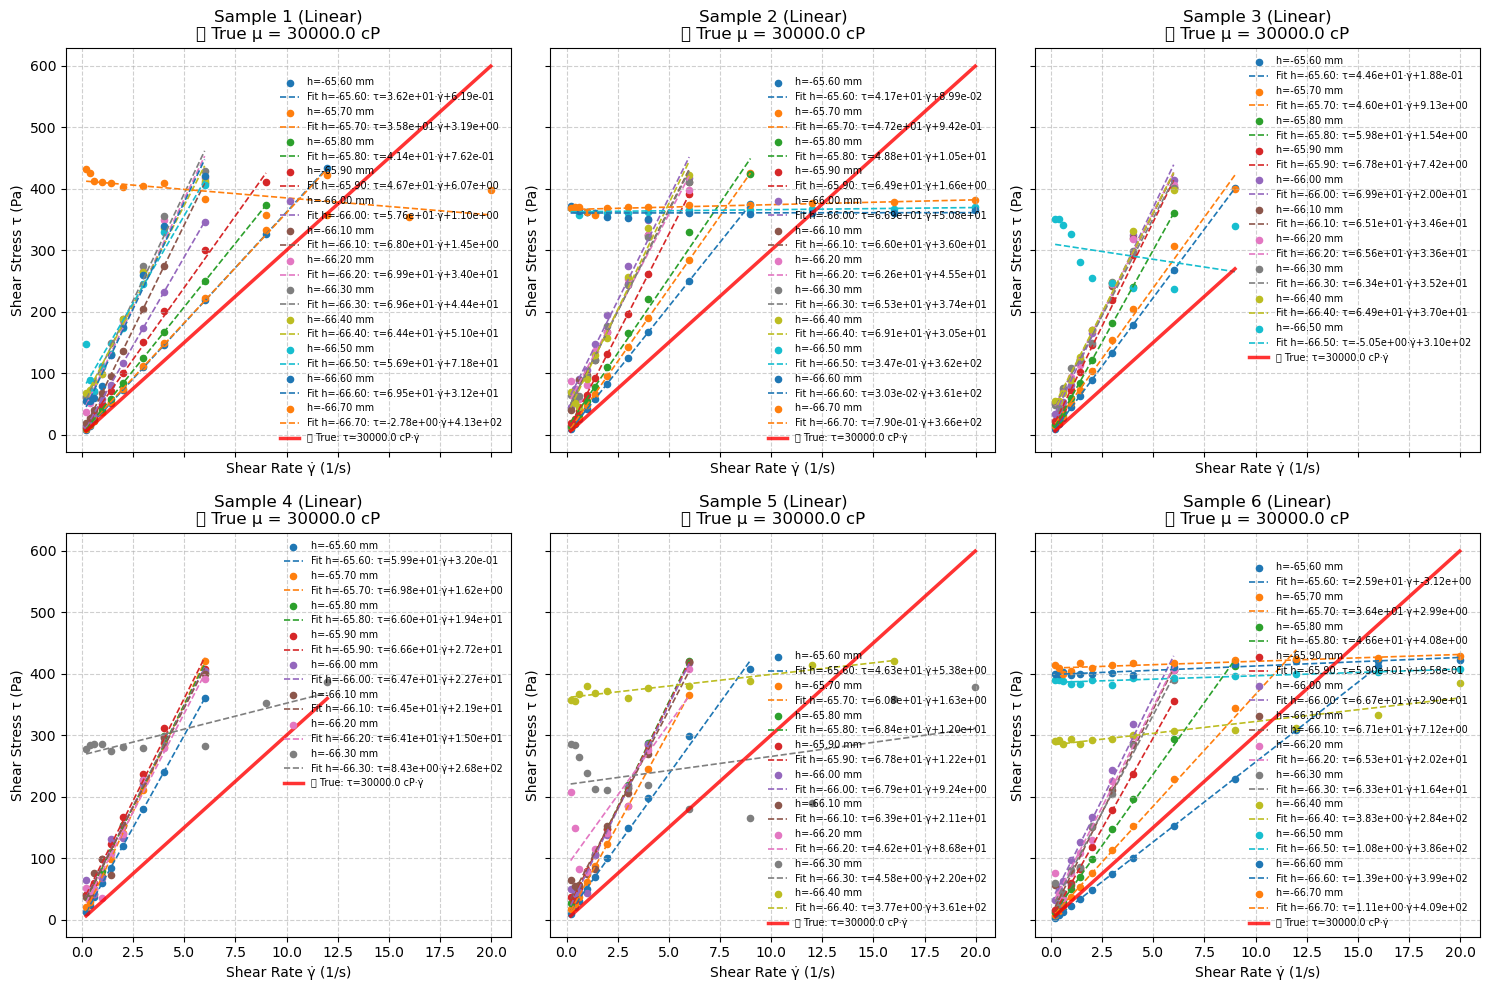


✅ Enhanced visualization complete!
🔍 Red line shows theoretical τ = μ·γ̇ relationship
📊 Compare experimental fits (dashed lines) vs theoretical line (solid red)


In [42]:
# Execute enhanced visualization with true viscosity comparison
print("🎯 Starting enhanced stress-strain visualization...")

# This will prompt you to enter the known viscosity for overlay
plot_fitted_stress_strain_with_true_viscosity(datasets, dataset_names, ALPHA_DEG, R_CM, 
                                            M_MAX, GAP_UM, fit_method="linear")

print("\n✅ Enhanced visualization complete!")
print("🔍 Red line shows theoretical τ = μ·γ̇ relationship")
print("📊 Compare experimental fits (dashed lines) vs theoretical line (solid red)")

# Alternative: You can also specify the true viscosity directly
# plot_fitted_stress_strain_with_true_viscosity(datasets, dataset_names, ALPHA_DEG, R_CM, 
#                                             M_MAX, GAP_UM, true_viscosity_cp=60000, 
#                                             fit_method="linear")

# 🎉 ENHANCED RHEOLOGY ANALYSIS COMPLETE

## 🆕 New Features Added Today:

### 1. **Interactive True Viscosity Comparison**
- `plot_fitted_stress_strain_with_true_viscosity()` function
- Overlays theoretical τ = μ·γ̇ line (red) on experimental data
- Interactive viscosity input for validation
- Perfect for validating measurements against known material properties

### 2. **Comprehensive Dataset Generation**
- `generate_enhanced_dataset()` function  
- Creates detailed datasets with:
  - ✅ Height measurements (mm)
  - ✅ Slope = viscosity (Pa·s)
  - ✅ Intercept (Pa)
  - ✅ Fitting uncertainties (from covariance matrix)
  - ✅ Slope error (% vs true viscosity)
  - ✅ Intercept error (absolute Pa vs ideal 0)

### 3. **Enhanced Error Analysis**
- Quantitative comparison vs. theoretical values
- Statistical uncertainty assessment
- Comprehensive quality metrics

## 📊 Usage Summary:

1. **Load Data**: Define file paths and load your rheometer data
2. **Set Parameters**: Configure cone-plate geometry parameters  
3. **Enhanced Analysis**: Run enhanced dataset generation
4. **Visualize**: Use true viscosity overlay plots for validation
5. **Analyze**: Review comprehensive error metrics and statistics

## 💡 Benefits:
- 🎯 **Validation**: Compare experimental vs. theoretical behavior
- 📊 **Quality Control**: Quantify measurement accuracy and precision
- 🔍 **Error Analysis**: Identify systematic biases and uncertainties
- 📈 **Comprehensive**: Full pipeline from raw data to statistical analysis

**Original `stress_strain.ipynb` remains unchanged!**  
*Enhanced functions are available in this new notebook.*